In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from datetime import date
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# read the dataset
df = pd.read_excel('Data_forecast_covid2022.xlsx')

In [3]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

In [4]:
df.Timestamp = pd.to_datetime(df.Tanggal, unit='Y')

C:\Users\HP\AppData\Local\Temp\ipykernel_8872\2680437410.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Timestamp = pd.to_datetime(df.Tanggal, unit='Y')


In [5]:
df.index = df.Tanggal
df.head()

,Tanggal,ID_KEC,Nama_provinsi,nama_kota,nama_kecamatan,POSITIF
Tanggal,,,,,,
2022-01-01,2022-01-01,317506,DKI JAKARTA,JAKARTA TIMUR,CAKUNG,22671
2022-01-01,2022-01-01,317105,DKI JAKARTA,JAKARTA PUSAT,CEMPAKA PUTIH,10538
2022-01-01,2022-01-01,317301,DKI JAKARTA,JAKARTA BARAT,CENGKARENG,28737
2022-01-01,2022-01-01,317406,DKI JAKARTA,JAKARTA SELATAN,CILANDAK,17708
2022-01-01,2022-01-01,317204,DKI JAKARTA,JAKARTA UTARA,CILINCING,17437


#  Resample to daily period

In [6]:
df_day = df.resample('D').mean()
missing_replacement = df['2022-01-25': '2022-01-28'].mean(numeric_only=True)
df_day.loc['2022-01-26'] = missing_replacement
df_day.loc['2022-01-27'] = missing_replacement
df_day.loc['2022-01-28'] = missing_replacement

df_day.isnull().sum()

POSITIF    0
dtype: int64

# Timeseries Visualization

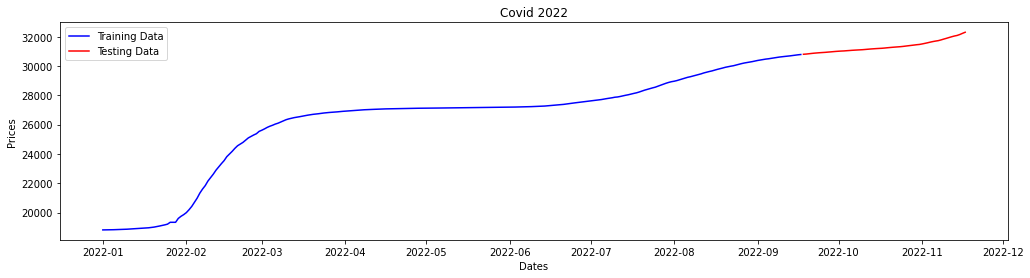

In [7]:
df_train = df_day.loc['2022-01-01':'2022-9-17']
df_test = df_day.loc['2022-9-18':]

plt.figure(figsize=(17, 4))
plt.title('Covid 2022')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train.POSITIF, 'blue', label='Training Data')
plt.plot(df_test.POSITIF, 'red', label='Testing Data')

plt.legend()

y_train = df_train.POSITIF.values
y_test = df_test.POSITIF.values

In [8]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print('Estimated differencing term:', n_diffs)

auto = pm.auto_arima(
    y_train, d=n_diffs, 
    seasonal=True, stepwise=True,
    suppress_warnings=True, error_action="ignore", 
    max_p=6, max_order=None, trace=True
)

Estimated differencing term: 2
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2349.112, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2428.208, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2400.772, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2373.557, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2370.139, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2350.544, Time=0.09 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=2336.796, Time=0.30 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=2346.133, Time=0.23 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=2336.250, Time=0.42 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=2341.755, Time=0.22 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=2337.407, Time=0.63 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=2336.931, Time=0.54 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=2336.985, Time=0.30 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=2340.469, Time=0.28 sec
 A

# Model Evaluation 

In [9]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

y_predict = []
y_confidence = []

for i, new_ob in enumerate(y_test):
    fc, conf = forecast_one_step()
    y_predict.append(fc)
    y_confidence.append(conf)
    
    print(i, fc, new_ob, abs(fc - new_ob))

    model.update(new_ob)

print('Mean squared error:', mean_squared_error(y_test, y_predict, squared=False))
print('Root Mean squared error:', mean_squared_error(y_test, y_predict))
print('R-Squared', r2_score(y_test, y_predict))

0 30808.879451560413 30804.347826086956 4.5316254734570975
1 30824.65304364213 30817.956521739132 6.6965219029989385
2 30835.219506911006 30838.652173913044 3.4326670020382153
3 30857.476102115503 30859.82608695652 2.349984841017431
4 30876.791321638306 30879.130434782608 2.339113144302246
5 30897.75526029922 30894.608695652172 3.1465646470460342
6 30912.174001429656 30909.543478260868 2.6305231687874766
7 30926.392342353378 30922.152173913044 4.240168440333946
8 30936.27845006327 30934.021739130436 2.256710932833812
9 30947.038168851654 30950.108695652172 3.0705268005185644
10 30963.551989404397 30965.217391304348 1.6654018999506661
11 30977.62096521657 30982.195652173912 4.574686957341328
12 30997.169719455225 30998.152173913044 0.982454457818676
13 31012.90792784224 31011.260869565216 1.6470582770234614
14 31026.06755994872 31023.239130434784 2.8284295139346796
15 31037.55074674235 31031.58695652174 5.963790220608644
16 31043.10753139285 31046.108695652172 3.0011642593235592
17 3105

# Visualize the prediction values

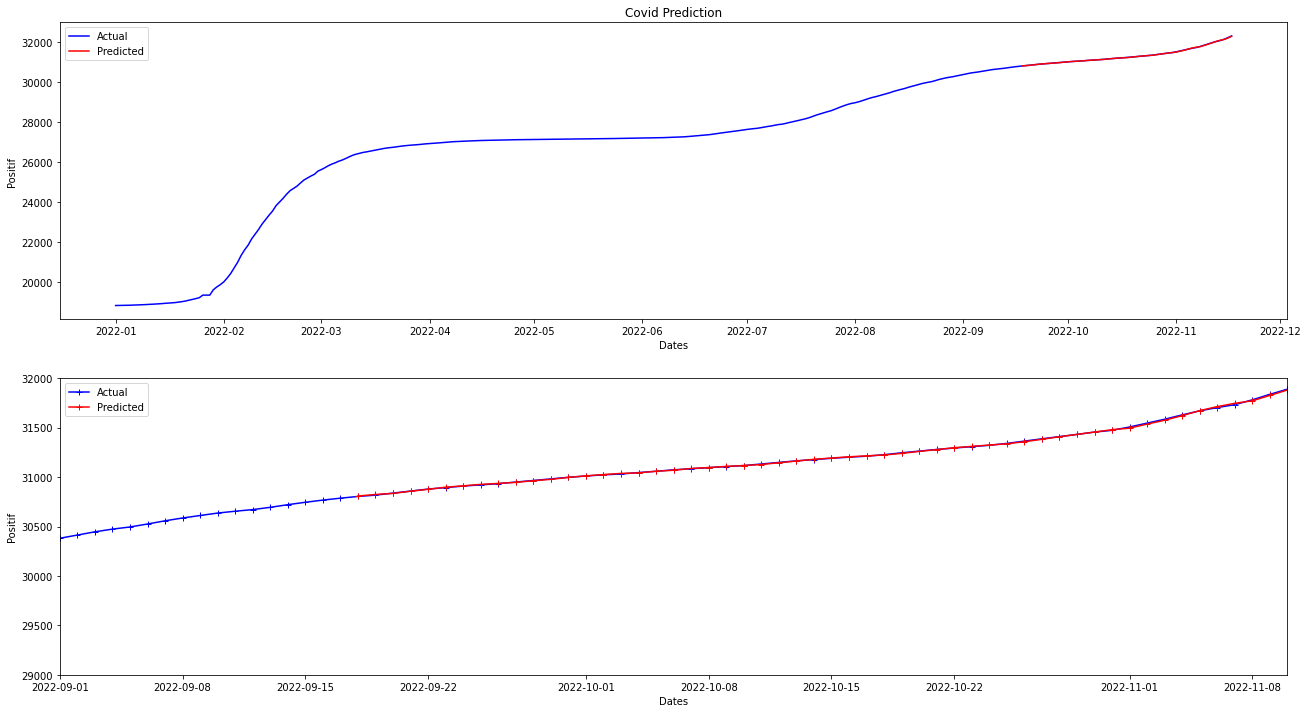

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(22, 12))

axes[0].plot(df_day.index, df_day.POSITIF, color='blue', label='Actual')
axes[0].plot(df_test.index, y_predict, color='red', label='Predicted')

axes[0].set_title('Covid Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Positif')
axes[0].legend()

axes[1].plot(df_day.index, df_day.POSITIF, ls='-', marker='+', color='blue', label='Actual')
axes[1].plot(df_test.index, y_predict, ls='-', marker='+', color='red', label='Predicted')

axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Positif')
axes[1].set_xlim(date(2022, 9, 1), date(2022, 11, 10))
axes[1].set_ylim(29000, 32000)
axes[1].legend()

plt.savefig('ARIMACov2022.jpg',  dpi=300, bbox_inches='tight')
plt.show()